In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST, FashionMNIST
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import animation, rc

# !apt install imagemagick # gif作成に必要


In [7]:
BATCH_SIZE = 100

trainval_data = MNIST("./data", 
                   train=True, 
                   download=True, 
                   transform=transforms.ToTensor())

train_size = int(len(trainval_data) * 0.8)
val_size = int(len(trainval_data) * 0.2)
train_data, val_data = torch.utils.data.random_split(trainval_data, [train_size, val_size])

train_loader = DataLoader(dataset=train_data,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=0)

val_loader = DataLoader(dataset=val_data,
                        batch_size=BATCH_SIZE,
                        shuffle=True,
                        num_workers=0)

print("train data size: ",len(train_data))   #train data size:  48000
print("train iteration number: ",len(train_data)//BATCH_SIZE)   #train iteration number:  480
print("val data size: ",len(val_data))   #val data size:  12000
print("val iteration number: ",len(val_data)//BATCH_SIZE)   #val iteration number:  120


train data size:  48000
train iteration number:  480
val data size:  12000
val iteration number:  120


images_size: torch.Size([100, 1, 28, 28])
label: tensor([6, 2, 6, 9, 1, 1, 8, 6, 4, 6])


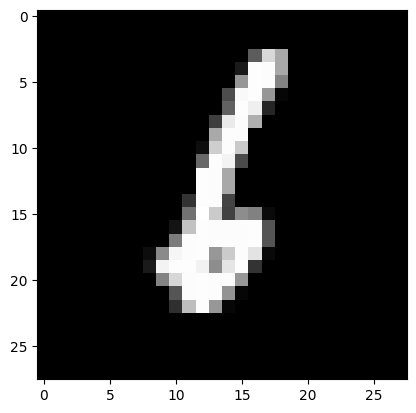

In [8]:
images, labels = next(iter(train_loader))
print("images_size:",images.size())   #images_size: torch.Size([100, 1, 28, 28])
print("label:",labels[:10])   #label: tensor([7, 6, 0, 6, 4, 8, 5, 2, 2, 3])

image_numpy = images.detach().numpy().copy()
plt.imshow(image_numpy[0,0,:,:], cmap='gray')


In [9]:
class Encoder(nn.Module):
  def __init__(self, z_dim):
    super().__init__()
    self.lr = nn.Linear(28*28, 300)
    self.lr2 = nn.Linear(300, 100)
    self.lr_ave = nn.Linear(100, z_dim)   #average
    self.lr_dev = nn.Linear(100, z_dim)   #log(sigma^2)
    self.relu = nn.ReLU()
  
  def forward(self, x):
    x = self.lr(x)
    x = self.relu(x)
    x = self.lr2(x)
    x = self.relu(x)
    ave = self.lr_ave(x)    #average
    log_dev = self.lr_dev(x)    #log(sigma^2)

    ep = torch.randn_like(ave)   #平均0分散1の正規分布に従い生成されるz_dim次元の乱数
    z = ave + torch.exp(log_dev / 2) * ep   #再パラメータ化トリック
    return z, ave, log_dev

class Decoder(nn.Module):
  def __init__(self, z_dim):
    super().__init__()
    self.lr = nn.Linear(z_dim, 100)
    self.lr2 = nn.Linear(100, 300)
    self.lr3 = nn.Linear(300, 28*28)
    self.relu = nn.ReLU()
  
  def forward(self, z):
    x = self.lr(z)
    x = self.relu(x)
    x = self.lr2(x)
    x = self.relu(x)
    x = self.lr3(x)
    x = torch.sigmoid(x)   #MNISTのピクセル値の分布はベルヌーイ分布に近いと考えられるので、シグモイド関数を適用します。
    return x

class VAE(nn.Module):
  def __init__(self, z_dim):
    super().__init__()
    self.encoder = Encoder(z_dim)
    self.decoder = Decoder(z_dim)
  
  def forward(self, x):
    z, ave, log_dev = self.encoder(x)
    x = self.decoder(z)
    return x, z, ave, log_dev


In [10]:
def criterion(predict, target, ave, log_dev):
  bce_loss = F.binary_cross_entropy(predict, target, reduction='sum')
  kl_loss = -0.5 * torch.sum(1 + log_dev - ave**2 - log_dev.exp())
  loss = bce_loss + kl_loss
  return loss


In [11]:
z_dim = 2
num_epochs = 20

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
model = VAE(z_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[15], gamma=0.1)

history = {"train_loss": [], "val_loss": [], "ave": [], "log_dev": [], "z": [], "labels":[]}

for epoch in range(num_epochs):
  model.train()
  for i, (x, labels) in enumerate(train_loader):
    input = x.to(device).view(-1, 28*28).to(torch.float32)
    output, z, ave, log_dev = model(input)

    history["ave"].append(ave)
    history["log_dev"].append(log_dev)
    history["z"].append(z)
    history["labels"].append(labels)
    loss = criterion(output, input, ave, log_dev)
     
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
     
    if (i+1) % 50 == 0:
      print(f'Epoch: {epoch+1}, loss: {loss: 0.4f}')
    history["train_loss"].append(loss)

  model.eval()
  with torch.no_grad():
    for i, (x, labels) in enumerate(val_loader):
      input = x.to(device).view(-1, 28*28).to(torch.float32)
      output, z, ave, log_dev = model(input)

      loss = criterion(output, input, ave, log_dev)
      history["val_loss"].append(loss)
      
    print(f'Epoch: {epoch+1}, val_loss: {loss: 0.4f}')
  
  scheduler.step()


Epoch: 1, loss:  20571.7266
Epoch: 1, loss:  19938.5859
Epoch: 1, loss:  18880.7207
Epoch: 1, loss:  18084.1211
Epoch: 1, loss:  18067.9473
Epoch: 1, loss:  17088.1504
Epoch: 1, loss:  17382.7324
Epoch: 1, loss:  17409.9668
Epoch: 1, loss:  17424.3672
Epoch: 1, val_loss:  16557.8906
Epoch: 2, loss:  17361.7324
Epoch: 2, loss:  16712.8516
Epoch: 2, loss:  16543.6133
Epoch: 2, loss:  15856.9824
Epoch: 2, loss:  16615.3242
Epoch: 2, loss:  16163.7314
Epoch: 2, loss:  16181.9404
Epoch: 2, loss:  15914.4717
Epoch: 2, loss:  15163.0566
Epoch: 2, val_loss:  16777.6270
Epoch: 3, loss:  16448.4453
Epoch: 3, loss:  16847.9316
Epoch: 3, loss:  16278.3584
Epoch: 3, loss:  16500.1074
Epoch: 3, loss:  15364.0781
Epoch: 3, loss:  15850.6846
Epoch: 3, loss:  15886.2979
Epoch: 3, loss:  15027.6807
Epoch: 3, loss:  15929.6445
Epoch: 3, val_loss:  15480.3545
Epoch: 4, loss:  16235.2969
Epoch: 4, loss:  15419.0508
Epoch: 4, loss:  16495.8574
Epoch: 4, loss:  14781.9258
Epoch: 4, loss:  16521.1582
Epoch: 4

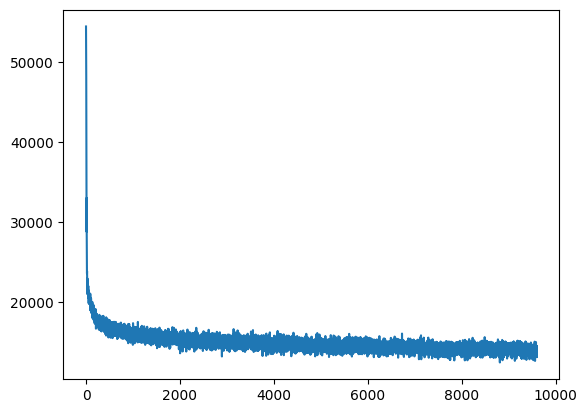

In [12]:
train_loss_tensor = torch.stack(history["train_loss"])
train_loss_np = train_loss_tensor.to('cpu').detach().numpy().copy()
plt.plot(train_loss_np)


In [13]:
ave_tensor = torch.stack(history["ave"])
log_var_tensor = torch.stack(history["log_dev"])
z_tensor = torch.stack(history["z"])
labels_tensor = torch.stack(history["labels"])
print(ave_tensor.size())   #torch.Size([9600, 100, 2])
print(log_var_tensor.size())   #torch.Size([9600, 100, 2])
print(z_tensor.size())   #torch.Size([9600, 100, 2])
print(labels_tensor.size())   #torch.Size([9600, 100])

ave_np = ave_tensor.to('cpu').detach().numpy().copy()
log_var_np = log_var_tensor.to('cpu').detach().numpy().copy()
z_np = z_tensor.to('cpu').detach().numpy().copy()
labels_np = labels_tensor.to('cpu').detach().numpy().copy()
print(ave_np.shape)   #(9600, 100, 2)
print(log_var_np.shape)   #(9600, 100, 2)
print(z_np.shape)   #(9600, 100, 2)
print(labels_np.shape)   #(9600, 100)


torch.Size([9600, 100, 2])
torch.Size([9600, 100, 2])
torch.Size([9600, 100, 2])
torch.Size([9600, 100])
(9600, 100, 2)
(9600, 100, 2)
(9600, 100, 2)
(9600, 100)


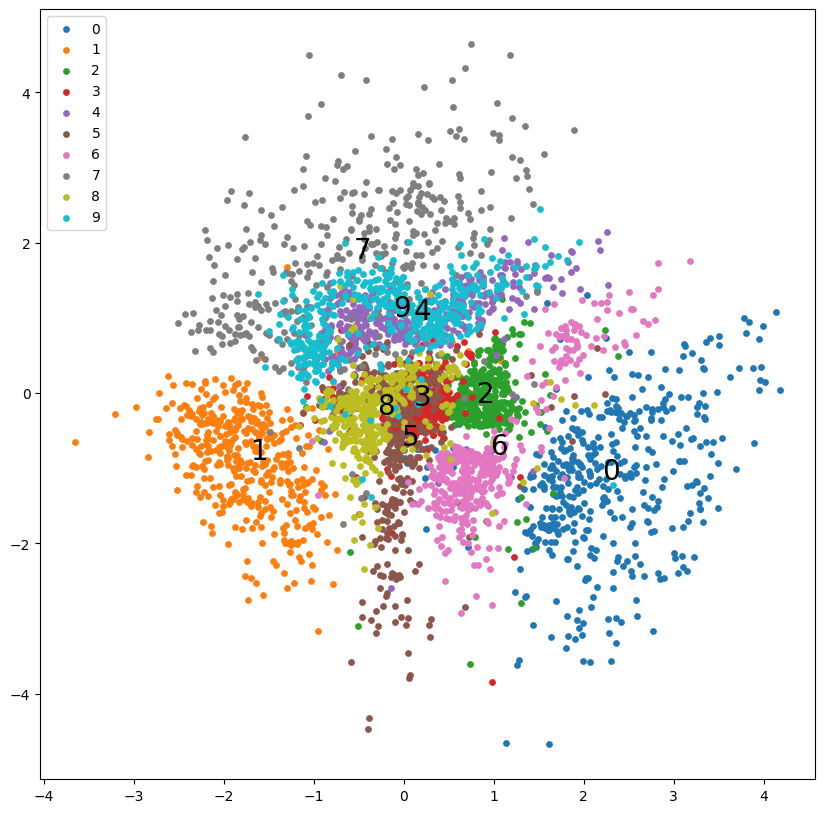

In [42]:
cmap = plt.get_cmap("tab10")
batch_num = 9560
plt.figure(figsize=[10,10])
for label in range(10):
  x = z_np[batch_num:,:,0][labels_np[batch_num:,:] == label]
  y = z_np[batch_num:,:,1][labels_np[batch_num:,:] == label]
  plt.scatter(x, y, color=cmap(label/9), label=label, s=15)
  plt.annotate(label, xy=(np.mean(x),np.mean(y)),size=20,color="black")
plt.legend(loc="upper left")


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

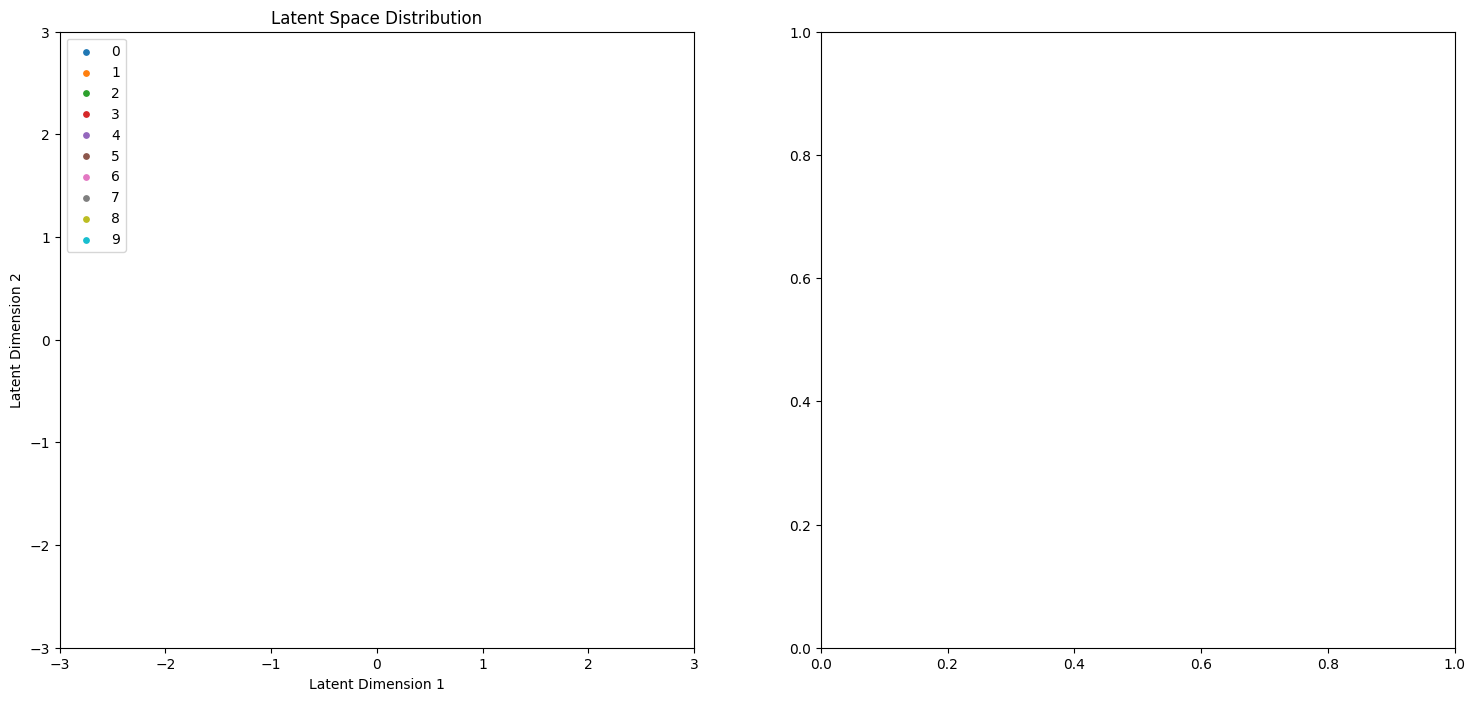

In [48]:
# サンプルデータ: 潜在変数 z とラベル（z_np と labels_np は事前に定義されている必要があります）
batch_num = 23850

# 潜在空間の範囲を固定
fixed_min, fixed_max = -3, 3  # 第一軸と第二軸の範囲
sample_range_x = np.linspace(fixed_min, fixed_max, 10)  # x軸方向: -3 から 3
sample_range_y = np.linspace(fixed_min, fixed_max, 10)  # y軸方向: -3 から 3

# 図の準備
fig, axes = plt.subplots(1, 2, figsize=(18, 8))  # 横並びで配置

# --- 1. 潜在空間の分布をプロット ---
scatter_ax = axes[0]
for label in range(10):
    x = z_np[batch_num:, :, 0][labels_np[batch_num:, :] == label]
    y = z_np[batch_num:, :, 1][labels_np[batch_num:, :] == label]
    scatter_ax.scatter(x, y, color=plt.cm.tab10(label / 9), label=label, s=15)
    scatter_ax.annotate(label, xy=(np.mean(x), np.mean(y)), size=15, color="black")

scatter_ax.set_xlim(fixed_min, fixed_max)  # x軸の範囲を固定
scatter_ax.set_ylim(fixed_min, fixed_max)  # y軸の範囲を固定
scatter_ax.set_xlabel("Latent Dimension 1")
scatter_ax.set_ylabel("Latent Dimension 2")
scatter_ax.set_title("Latent Space Distribution")
scatter_ax.legend(loc="upper left")

# --- 2. 潜在空間の各点で生成される画像を可視化 ---
image_ax = axes[1]

# 生成画像の数を4倍に増やす（範囲を細かく分割）
num_points = 40  # 点の数を増やす
sample_range_x = np.linspace(fixed_min, fixed_max, num_points)  # x軸方向
sample_range_y = np.linspace(fixed_min, fixed_max, num_points)  # y軸方向

# 各点で生成された画像をプロット
image_size = (fixed_max - fixed_min) / num_points  # 各画像の幅と高さを計算
for i, x in enumerate(sample_range_x):
    for j, y in enumerate(sample_range_y):
        z_sample = torch.tensor([x, y], dtype=torch.float32)
        output = model.decoder(z_sample)  # VAEデコーダを使用して画像生成
        np_output = output.detach().numpy().copy()
        np_image = np.reshape(np_output, (28, 28))

        # 画像を潜在空間の対応する座標に直接プロット（余白なし）
        image_ax.imshow(
            np_image, 
            extent=(x, x + image_size, y, y + image_size), 
            cmap="gray", 
            alpha=0.8
        )

# 軸範囲を固定
image_ax.set_xlim(fixed_min, fixed_max)  # x軸の範囲を固定
image_ax.set_ylim(fixed_min, fixed_max)  # y軸の範囲を固定
image_ax.set_xlabel("Latent Dimension 1")
image_ax.set_ylabel("Latent Dimension 2")
image_ax.set_title("Generated Images in Latent Space")


# 図を表示
plt.tight_layout()
plt.show()


In [ ]:
import seaborn as sns
from scipy.stats import gaussian_kde

# 潜在変数を2次元のリストに展開
z_points = np.concatenate(z_np[batch_num:], axis=0)  # shape: (サンプル数, 2)

# KDE（カーネル密度推定）による分布の推定
kde = gaussian_kde(z_points.T)
x_grid, y_grid = np.meshgrid(
    np.linspace(fixed_min, fixed_max, 100),
    np.linspace(fixed_min, fixed_max, 100)
)
grid_coords = np.vstack([x_grid.ravel(), y_grid.ravel()])
density = kde(grid_coords).reshape(x_grid.shape)

# ヒートマッププロット
plt.figure(figsize=(8, 6))
sns.heatmap(
    density, 
    xticklabels=False, 
    yticklabels=False, 
    cmap="viridis", 
    cbar=True,
    square=True
)
plt.title("Latent Space Density")
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.show()


NameError: name 'z_np' is not defined